In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rfest import splineLG

## Make 1D Receptive Field

In [2]:
def mkcov_ASD(length, rho, nk):
    
    """
    Generate ASD covariance matrix, also known as RBF or squared-exponential kernel
    
    Parameters
    ==========
    length: float 
        length scale of ASD kernel (determines smoothness)
    rho: float
        maximal prior variance ("overall scale")
    nk: int
        number of indices (sidelength of covariance matrix)
        
    Return
    ======
    C:　matrix (nk, nk)
        covariance matrix
    """
    
    indices = np.arange(1, nk+1)
    square_distance = (indices - indices.reshape(-1,1)) ** 2
    C = rho * np.exp(-.5 * square_distance / length ** 2)
    
    return C

nk = 1000 # number of filter coeffs (1D vector)
rho = 2 # marginal variance of prior
length = 50 # length scale of prior
C0 = mkcov_ASD(length, rho, nk)

# Sample true filter from the prior distribution
np.random.seed(1990)
k_true = np.random.multivariate_normal(np.zeros(nk), C0)


# Generate stimuli and sample responses from model
from scipy.ndimage import gaussian_filter

nsamps = 1000
signse = 10
Stim = gaussian_filter(np.random.randn(nk, nsamps), 1).T
X = Stim.copy()
y = Stim @ k_true + np.random.randn(nsamps) * signse

## Fit Linear Gaussian model with B-Spline, Natural Cubic Regression Spline and Thin Plate Regression Spline

In [3]:
df = 13
dims = [nk, ]

print('\nFitting with B-Spline...\n')
bs = splineLG(X, y, dims=dims, df=df, smooth='bs', compute_mle=True)
bs.fit(num_iters=1500, alpha=1, lambd=0.025, verbal=100)

print('\nFitting with Natural Cubic Regression Spline...\n')
cr = splineLG(X, y, dims=dims, df=df, smooth='cr', compute_mle=False)
cr.fit(num_iters=1500, alpha=1, lambd=0.025, verbal=100)

print('\nFitting with Thin Plate Regression Spline...\n')
tp = splineLG(X, y, dims=dims, df=df, smooth='tp', compute_mle=False)
tp.fit(num_iters=1500, alpha=1, lambd=0.025, verbal=100)


Fitting with B-Spline...

Iter	Cost	
0	161.634	
Stop at 55 steps: cost has been changing less than 1e-5 for 10 steps.

Fitting with Natural Cubic Regression Spline...

Iter	Cost	
0	124.367	
Stop at 68 steps: cost has been changing less than 1e-5 for 10 steps.

Fitting with Thin Plate Regression Spline...

Iter	Cost	
0	161.470	
100	161.381	
Stop at 115 steps: cost has been changing less than 1e-5 for 10 steps.


## Plot Results

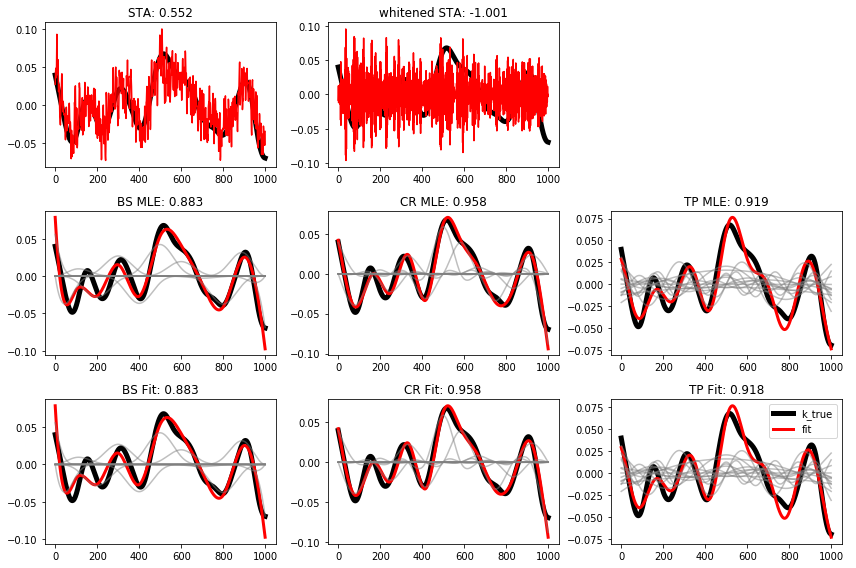

In [4]:
from sklearn.metrics import r2_score
def performance(k, kopt):
    return r2_score(k, kopt)

def norm(k):
    return k / np.linalg.norm(k)

STA = bs.w_sta
MLE = bs.w_mle

fig, ax = plt.subplots(3,3, figsize=(12, 8))
ax = ax.flatten()

ax[0].plot(norm(k_true), color='black', lw=5, label='k_true')
ax[0].plot(norm(STA), color='red', label='mle')
ax[0].set_title('STA: {0:.3f}'.format(performance(norm(k_true), norm(STA))))


ax[1].plot(norm(k_true), color='black', lw=5, label='k_true')
ax[1].plot(norm(MLE), color='red', label='mle')
ax[1].set_title('whitened STA: {0:.3f}'.format(performance(norm(k_true), norm(MLE))))

ax[2].axis('off')

# Spline MLE

ax[3].plot(norm(k_true), color='black', lw=5, label='k_true')
ax[3].plot(norm(bs.w_spl), color='red', label='fit', lw=3)
ax[3].plot(norm(bs.S * bs.b_spl) , color='grey', alpha=0.5)
ax[3].set_title('BS MLE: {0:.3f}'.format(performance(norm(k_true),norm(bs.w_spl))))

ax[4].plot(norm(k_true), color='black', lw=5, label='k_true')
ax[4].plot(norm(cr.w_spl), color='red', label='fit', lw=3)
ax[4].plot(norm(cr.S * cr.b_spl), color='grey', alpha=0.5)
ax[4].set_title('CR MLE: {0:.3f}'.format(performance(norm(k_true), norm(cr.w_spl))))

ax[5].plot(norm(k_true), color='black', lw=5, label='k_true')
ax[5].plot(norm(tp.w_spl), color='red', label='fit', lw=3)
ax[5].plot(norm(tp.S * tp.b_spl) , color='grey', alpha=0.5)
ax[5].set_title('TP MLE: {0:.3f}'.format(performance(norm(k_true),norm(tp.w_spl))))

# Spline fitted with L1

ax[6].plot(norm(k_true), color='black', lw=5, label='k_true')
ax[6].plot(norm(bs.w_opt), color='red', label='fit', lw=3)
ax[6].plot(norm(bs.S * bs.b_opt), color='grey', alpha=0.5)
ax[6].set_title('BS Fit: {0:.3f}'.format(performance(norm(k_true), norm(bs.w_opt))))

ax[7].plot(norm(k_true), color='black', lw=5, label='k_true')
ax[7].plot(norm(cr.w_opt), color='red', label='fit', lw=3)
ax[7].plot(norm(cr.S * cr.b_opt), color='grey', alpha=0.5)
ax[7].set_title('CR Fit: {0:.3f}'.format(performance(norm(k_true), norm(cr.w_opt))))

ax[8].plot(norm(k_true), color='black', lw=5, label='k_true')
ax[8].plot(norm(tp.w_opt), color='red', label='fit', lw=3)
ax[8].plot(norm(tp.S * tp.b_opt), color='grey', alpha=0.5)
ax[8].set_title('TP Fit: {0:.3f}'.format(performance(norm(k_true), norm(tp.w_opt))))

plt.legend()
plt.tight_layout()